In [ ]:
# DATA 6505 – Group 1 – Data Preparation & Preprocessing
# Dataset: Fake and Real News Dataset (Kaggle)

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 3. Load the data

fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data6505_Fall_2025/Fake.csv")
true = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Data6505_Fall_2025/True.csv")
#fake = pd.read_csv("/Fake.csv")
#true = pd.read_csv("/True.csv")
print(f"Fake news shape : {fake.shape}")
print(f"Real news shape : {true.shape}")

Fake news shape : (23481, 4)
Real news shape : (21417, 4)


In [ ]:
# NLTK for tokenization, stopwords and stemming
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

# 4. Add labels (standard: Fake = 1, Real = 0)
fake['label'] = 1
true['label'] = 0

# 5. Concatenate
df = pd.concat([fake, true], ignore_index=True)
print(f"\nCombined shape: {df.shape}")
df.head()

# 6. Basic info & missing values
print("\nMissing values:")
print(df.isnull().sum())

# Very small number of missing titles/texts – drop them
df = df.dropna(subset=['title', 'text']).reset_index(drop=True)

# 7. Remove exact duplicates (same title + text)
print(f"Rows before duplicate removal: {len(df)}")
df = df.drop_duplicates(subset=['title', 'text']).reset_index(drop=True)
print(f"Rows after duplicate removal : {len(df)}")

# 8. Text cleaning function
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', text)
    # Remove emails
    text = re.sub(r'\S*@\S*\s?', ' ', text)
    # Remove HTML tags and weird \x96 dashes common in this dataset
    text = re.sub(r'<.*?>', ' ', text)
    text = text.replace('\x96', ' ').replace('–', ' ').replace('—', ' ')
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

print("\nCleaning title and text columns...")
df['title_clean'] = df['title'].apply(clean_text)
df['text_clean']  = df['text'].apply(clean_text)

# Optional: combine title + text (many groups get better performance this way)
df['full_text'] = df['title_clean'] + " [SEP] " + df['text_clean']

# 9. Tokenization + stopword removal (for TF-IDF path)
def tokenize_clean_and_stem(text):
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]  # keep only words
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens
              if token.isalpha() and token not in stop_words]
    return tokens

print("Tokenizing + removing stopwords + stemming...")
df['tokens'] = df['full_text'].apply(tokenize_clean_and_stem)

# 10. Final dataset info
print(f"\nFinal clean dataset shape: {df.shape}")
print(f"Class balance → Fake (1): {df['label'].mean():.3f} | Real (0): {1-df['label'].mean():.3f}")

# 11. Save the clean dataset for the rest of the team
df.to_csv('cleaned_news_dataset.csv', index=False)
print("\nSaved → cleaned_news_dataset.csv")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Combined shape: (44898, 5)

Missing values:
title      0
text       0
subject    0
date       0
label      0
dtype: int64
Rows before duplicate removal: 44898
Rows after duplicate removal : 39105

Cleaning title and text columns...
Tokenizing + removing stopwords + stemming...

Final clean dataset shape: (39105, 9)
Class balance → Fake (1): 0.458 | Real (0): 0.542

Saved → cleaned_news_dataset.csv


In [ ]:
view = pd.read_csv("/content/cleaned_news_dataset.csv")
view.head()

,title,text,subject,date,label,title_clean,text_clean,full_text,tokens
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,donald trump sends out embarrassing new year’s...,donald trump just couldn t wish all americans ...,donald trump sends out embarrassing new year’s...,"['donald', 'trump', 'send', 'embarrass', 'new'..."
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,drunk bragging trump staffer started russian c...,house intelligence committee chairman devin nu...,drunk bragging trump staffer started russian c...,"['drunk', 'brag', 'trump', 'staffer', 'start',..."
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,sheriff david clarke becomes an internet joke ...,"on friday, it was revealed that former milwauk...",sheriff david clarke becomes an internet joke ...,"['sheriff', 'david', 'clark', 'becom', 'intern..."
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,trump is so obsessed he even has obama’s name ...,"on christmas day, donald trump announced that ...",trump is so obsessed he even has obama’s name ...,"['trump', 'obsess', 'even', 'obama', 'name', '..."
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,pope francis just called out donald trump duri...,pope francis used his annual christmas day mes...,pope francis just called out donald trump duri...,"['pope', 'franci', 'call', 'donald', 'trump', ..."


In [ ]:
# 12. Feature Engineering (RQ1) – Title & Text Length Metrics


print("\n# 12. Length feature engineering (RQ1 – title/text length)...")

# Helpful label for plots: 1 = Fake, 0 = Real
df['label_name'] = df['label'].map({1: 'Fake', 0: 'Real'})

# Title length: characters and words (using cleaned title text)
df['title_len_chars'] = df['title_clean'].astype(str).str.len()
df['title_len_words'] = df['title_clean'].astype(str).str.split().apply(len)

# Text length: characters and words (using cleaned article text)
df['text_len_chars'] = df['text_clean'].astype(str).str.len()
df['text_len_words'] = df['text_clean'].astype(str).str.split().apply(len)

print(df[['title_len_chars', 'title_len_words',
          'text_len_chars', 'text_len_words']].head())




# 12. Length feature engineering (RQ1 – title/text length)...
   title_len_chars  title_len_words  text_len_chars  text_len_words
0               78               12            2671             482
1               68                8            1894             305
2               89               15            3338             565
3               77               14            2539             432
4               69               11            2332             420


In [ ]:
# 13. Descriptive Statistics for RQ1 – Length Features


print("\n# 13. Descriptive statistics for length features...")

# Overall stats
overall_stats = df[['title_len_chars', 'title_len_words',
                    'text_len_chars', 'text_len_words']].describe().round(2)

print("\nOverall length statistics:")
print(overall_stats)

# Stats by Fake vs Real
group_stats = df.groupby('label_name')[[
    'title_len_chars', 'title_len_words',
    'text_len_chars', 'text_len_words'
]].agg(['mean', 'median', 'std', 'min', 'max']).round(2)

print("\nLength statistics by class (Fake vs Real):")
print(group_stats)




# 13. Descriptive statistics for length features...

Overall length statistics:
       title_len_chars  title_len_words  text_len_chars  text_len_words
count         39105.00         39105.00        39105.00        39105.00
mean             76.56            11.94         2404.03          397.74
std              22.22             3.67         1924.21          314.66
min               0.00             0.00            0.00            0.00
25%              62.00             9.00         1254.00          208.00
50%              71.00            11.00         2190.00          365.00
75%              86.00            14.00         3045.00          507.00
max             279.00            42.00        51482.00         8134.00

Length statistics by class (Fake vs Real):
           title_len_chars                        title_len_words         \
                      mean median    std min  max            mean median   
label_name                                                                 


# 14. Plotting title length distributions...


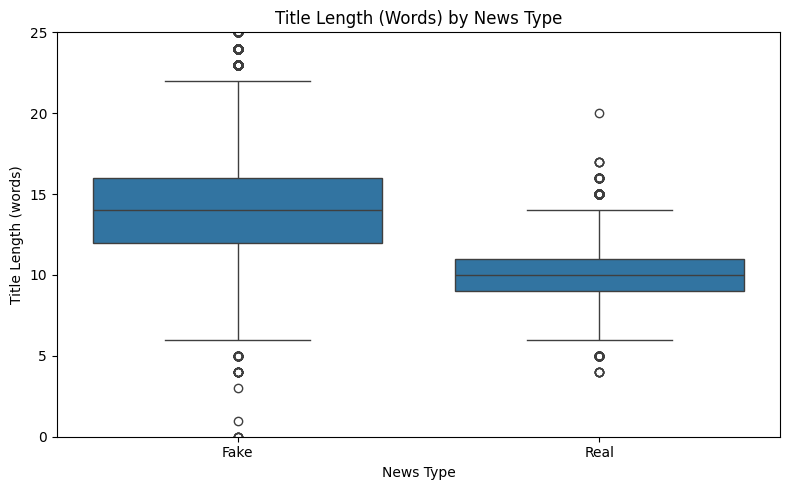

In [ ]:
# 14. Visualization 1 – Title length (words) by news type

print("\n# 14. Plotting title length distributions...")

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='label_name', y='title_len_words')
plt.title('Title Length (Words) by News Type')
plt.xlabel('News Type')
plt.ylabel('Title Length (words)')

# Focus on central distribution (trim extreme outliers at 99th percentile)
ymax_title = df['title_len_words'].quantile(0.99)
plt.ylim(0, ymax_title)

plt.tight_layout()
plt.show()





# 15. Plotting text length distributions...


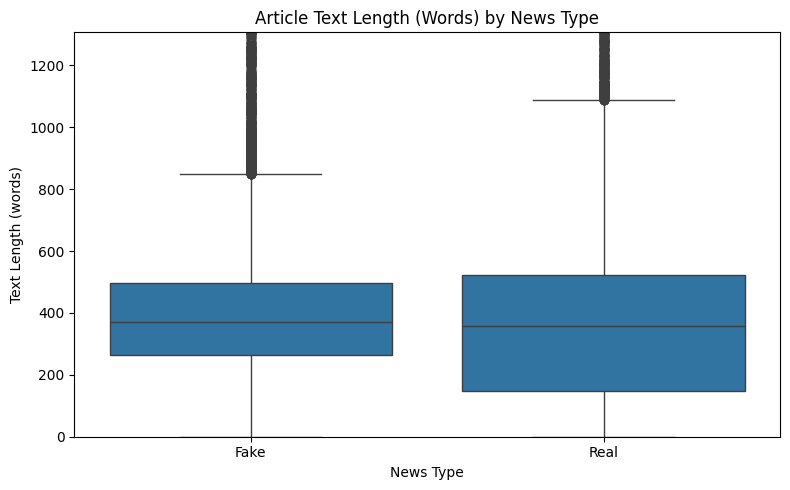

In [ ]:
# 15. Visualization 2 – Article text length (words) by news type

print("\n# 15. Plotting text length distributions...")

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='label_name', y='text_len_words')
plt.title('Article Text Length (Words) by News Type')
plt.xlabel('News Type')
plt.ylabel('Text Length (words)')

ymax_text = df['text_len_words'].quantile(0.99)
plt.ylim(0, ymax_text)

plt.tight_layout()
plt.show()



# 16. Histogram of Title Length (Words): Fake vs Real


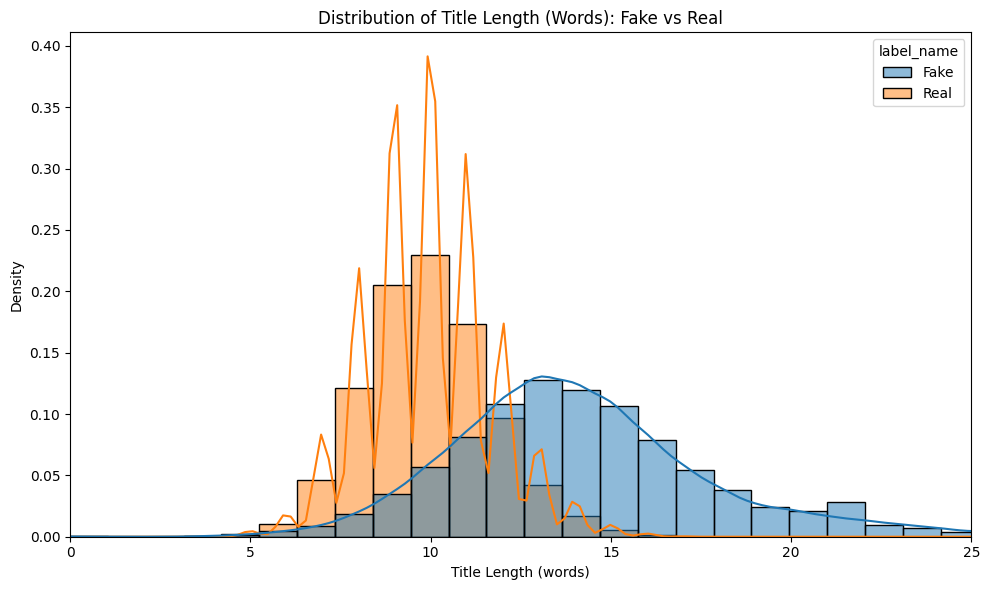

In [ ]:
# 16. Extra visual Histogram – Title length (words) distribution (Fake vs Real)

print("\n# 16. Histogram of Title Length (Words): Fake vs Real")

plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x='title_len_words',
    hue='label_name',
    bins=40,
    kde=True,
    stat='density',
    common_norm=False
)

plt.title('Distribution of Title Length (Words): Fake vs Real')
plt.xlabel('Title Length (words)')
plt.ylabel('Density')

# Trim extreme outliers
plt.xlim(0, df['title_len_words'].quantile(0.99))

plt.tight_layout()
plt.show()



# 17. Histogram of Article Text Length (Words): Fake vs Real


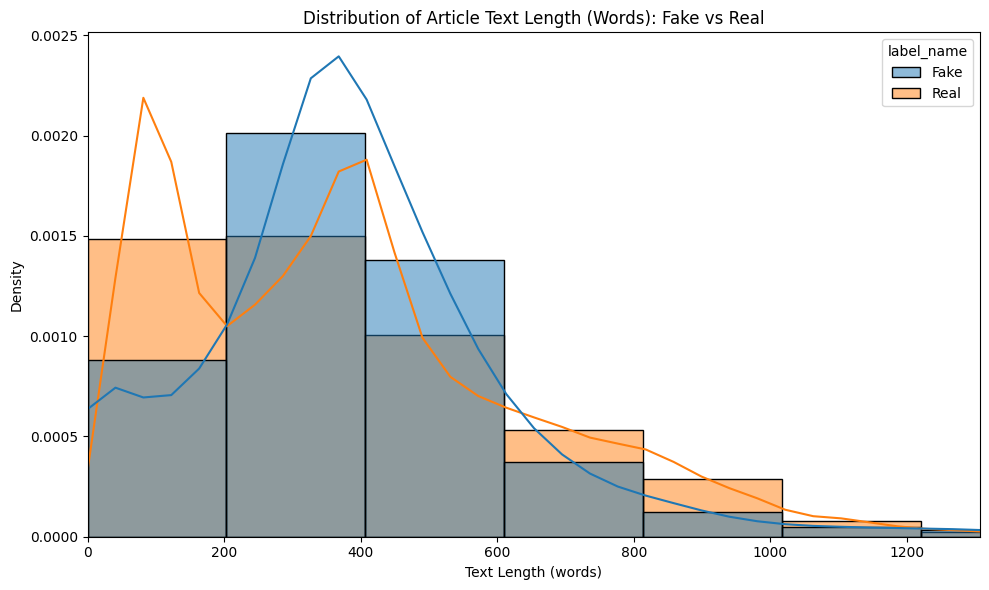

In [ ]:
# 17. Extra visual Histogram – Article text length (words) distribution (Fake vs Real)

print("\n# 17. Histogram of Article Text Length (Words): Fake vs Real")

plt.figure(figsize=(10,6))
sns.histplot(
    data=df,
    x='text_len_words',
    hue='label_name',
    bins=40,
    kde=True,
    stat='density',
    common_norm=False
)

plt.title('Distribution of Article Text Length (Words): Fake vs Real')
plt.xlabel('Text Length (words)')
plt.ylabel('Density')

# Trim extreme outliers to improve readability
plt.xlim(0, df['text_len_words'].quantile(0.99))

plt.tight_layout()
plt.show()


In [ ]:
# 18. Feature Engineering (RQ2) – Punctuation, ALL CAPS, and Stylistic Language

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

clean_text_col = 'text_clean'
raw_text_col = 'text'
label_col = 'label'


df["exclamation_count"] = df[clean_text_col].str.count("!")

df["question_count"] = df[clean_text_col].str.count("\\?")

def count_all_caps(text):
    if isinstance(text, str):
        return len(re.findall(r"\b[A-Z]{2,}\b", text))
    return 0

df["allcaps_count"] = df[raw_text_col].apply(count_all_caps)

keywords = ["breaking", "shocking", "exclusive", "urgent", "alert", "must see"]

def keyword_flag(text):
    if isinstance(text, str):
        return int(any(kw in text for kw in keywords))
    return 0

df["keyword_flag"] = df[clean_text_col].apply(keyword_flag)


In [ ]:
# 19. Feature Engineering (RQ2) – Stylistic Language

keywords = ["breaking", "shocking", "exclusive", "urgent", "alert", "must see"]

for kw in keywords:
    df[f"keyword_{kw.replace(' ', '_')}"] = df[clean_text_col].str.contains(kw).astype(int)

In [ ]:
# 20. Feature Engineering (RQ2) – Total Count

counts = (
    df[label_col]
    .value_counts()
    .rename({0: "Real News", 1: "Fake News"})
)

print("Article Counts by News Type:")
print(counts)



Article Counts by News Type:
label
Real News    21197
Fake News    17908
Name: count, dtype: int64



Average Keyword Appearance Rate per Article:

                   Real News  Fake News
keyword_breaking    0.017644   0.035180
keyword_shocking    0.002548   0.023677
keyword_exclusive   0.005378   0.018037
keyword_urgent      0.031797   0.006422
keyword_alert       0.007926   0.011112
keyword_must_see    0.000566   0.000614

Average Keyword Appearance Rate Differences (Fake - Real):

                   Real News  Fake News  Difference (Fake - Real)
keyword_breaking    0.017644   0.035180                  0.017536
keyword_shocking    0.002548   0.023677                  0.021129
keyword_exclusive   0.005378   0.018037                  0.012659
keyword_urgent      0.031797   0.006422                 -0.025375
keyword_alert       0.007926   0.011112                  0.003187
keyword_must_see    0.000566   0.000614                  0.000048


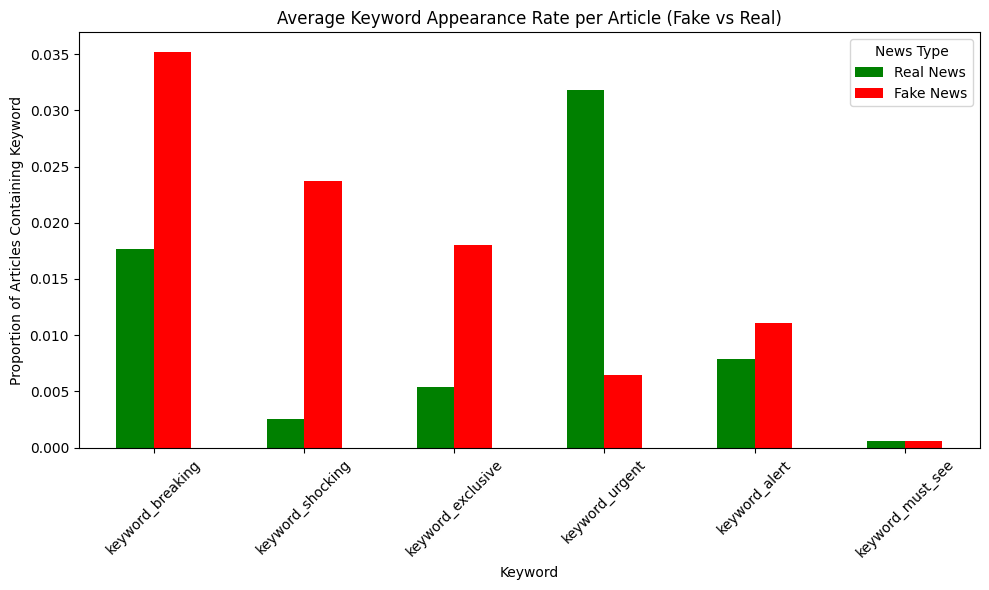

In [ ]:
#21. Visual 1: Average Keyword Appearance Rates + Printed Summary

keyword_cols = [f"keyword_{kw.replace(' ', '_')}" for kw in keywords]

keyword_means = df.groupby(label_col)[keyword_cols].mean().T
keyword_means.columns = ["Real News", "Fake News"]

print("\nAverage Keyword Appearance Rate per Article:\n")
print(keyword_means)

keyword_means["Difference (Fake - Real)"] = (
    keyword_means["Fake News"] - keyword_means["Real News"]
)
print("\nAverage Keyword Appearance Rate Differences (Fake - Real):\n")
print(keyword_means)

keyword_means[["Real News", "Fake News"]].plot(
    kind="bar",
    figsize=(10,6),
    color=["green", "red"]
)

plt.title("Average Keyword Appearance Rate per Article (Fake vs Real)")
plt.ylabel("Proportion of Articles Containing Keyword")
plt.xlabel("Keyword")
plt.xticks(rotation=45)
plt.legend(title="News Type")
plt.tight_layout()
plt.show()



Average Stylistic Feature Usage per Article:

                   Real News  Fake News
exclamation_count   0.061424   0.706779
question_count      0.099731   1.163614
allcaps_count       3.602114   5.485202

Average Stylistic Feature Differences (Fake - Real):

                   Real News  Fake News  Difference (Fake - Real)
exclamation_count   0.061424   0.706779                  0.645355
question_count      0.099731   1.163614                  1.063883
allcaps_count       3.602114   5.485202                  1.883089


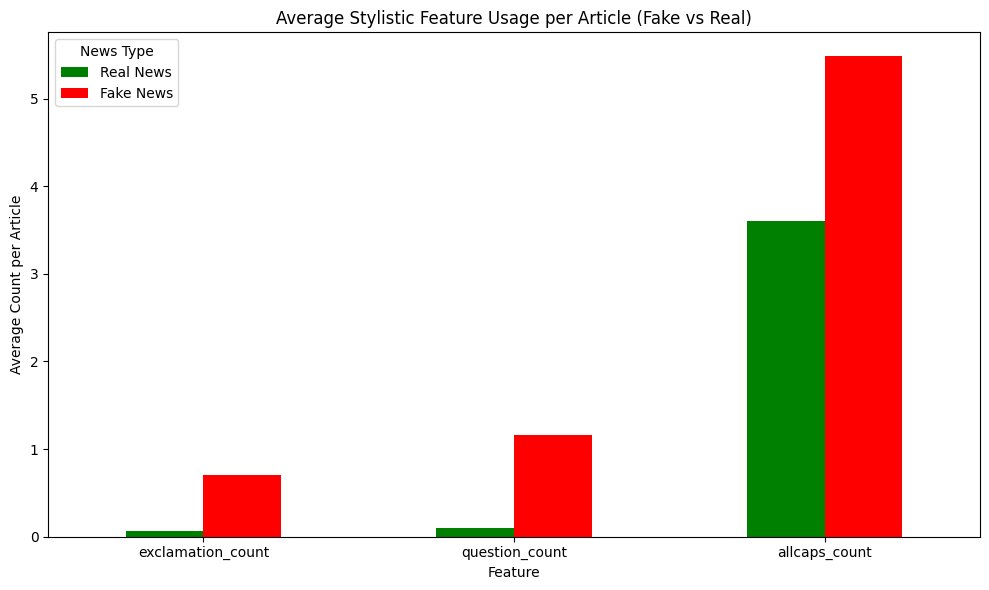

In [ ]:
#22. Visual 2: Average stylistic features per article

stylistic_cols = ["exclamation_count", "question_count", "allcaps_count"]

feature_means = df.groupby(label_col)[stylistic_cols].mean().T
feature_means.columns = ["Real News", "Fake News"]

print("\nAverage Stylistic Feature Usage per Article:\n")
print(feature_means)

feature_means["Difference (Fake - Real)"] = (
    feature_means["Fake News"] - feature_means["Real News"]
)
print("\nAverage Stylistic Feature Differences (Fake - Real):\n")
print(feature_means)

feature_means[["Real News", "Fake News"]].plot(
    kind="bar",
    figsize=(10,6),
    color=["green", "red"]
)

plt.title("Average Stylistic Feature Usage per Article (Fake vs Real)")
plt.ylabel("Average Count per Article")
plt.xlabel("Feature")
plt.xticks(rotation=0)
plt.legend(title="News Type")
plt.tight_layout()
plt.show()



Proportion of Articles Containing Each Stylistic Feature:

                    Real News  Fake News
exclamation_binary   0.037647   0.310867
question_binary      0.063216   0.466942
allcaps_binary       0.973534   0.790038


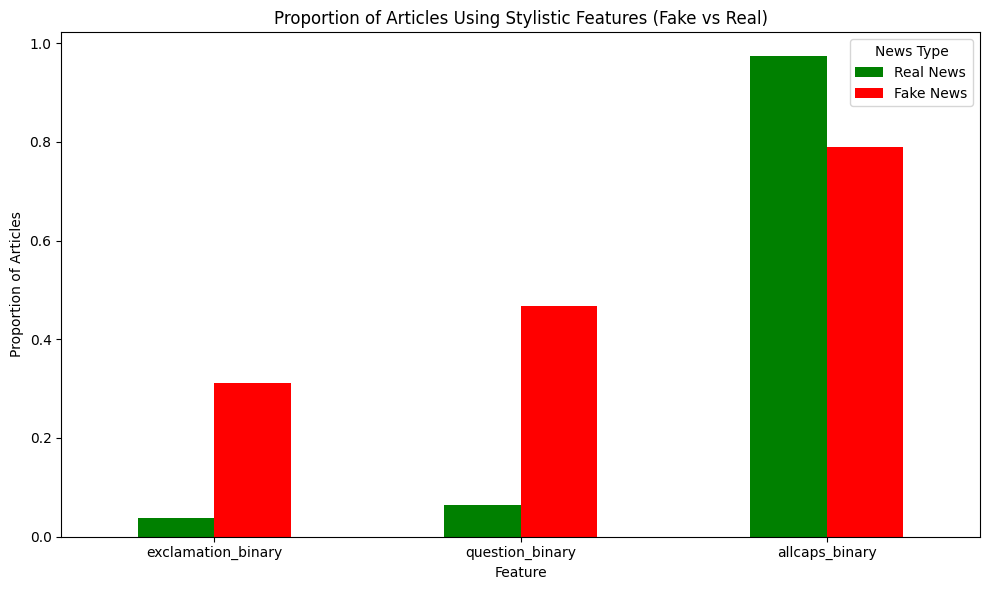

In [ ]:
# 23. Visual 3 - Proportion Stylistic
df[["exclamation_binary", "question_binary", "allcaps_binary"]] = (
    df[["exclamation_count", "question_count", "allcaps_count"]] > 0
).astype(int)

binary_cols = ["exclamation_binary", "question_binary", "allcaps_binary"]
binary_means = df.groupby(label_col)[binary_cols].mean().T
binary_means.columns = ["Real News", "Fake News"]

print("\nProportion of Articles Containing Each Stylistic Feature:\n")
print(binary_means)

binary_means.plot(kind="bar", figsize=(10,6), color=["green", "red"])
plt.title("Proportion of Articles Using Stylistic Features (Fake vs Real)")
plt.ylabel("Proportion of Articles")
plt.xlabel("Feature")
plt.xticks(rotation=0)
plt.legend(title="News Type")
plt.tight_layout()
plt.show()


In [ ]:
# Cell 1: Feature Engineering
# RQ3: Numerical and Statistical Indicators


import re
from scipy import stats

print("\n# 3.3 RQ3: Numerical and Statistical Indicators – Andrew")

df['digit_count'] = df['text_clean'].astype(str).apply(lambda x: len(re.findall(r'\d', x)))
df['number_count'] = df['text_clean'].astype(str).apply(lambda x: len(re.findall(r'\b\d+(?:[.,]\d+)*\b', x)))
df['percent_count'] = df['text_clean'].astype(str).apply(lambda x: x.count('%'))
df['dollar_count'] = df['text_clean'].astype(str).apply(lambda x: x.count('$'))

print(df[['digit_count', 'number_count', 'percent_count', 'dollar_count']].head())


# 3.3 RQ3: Numerical and Statistical Indicators – Andrew
   digit_count  number_count  percent_count  dollar_count
0          102            21              0             0
1            4             1              0             0
2           92            15              0             0
3           69            15              0             0
4            0             0              0             0


In [ ]:
# Cell 2: Descriptive Statistics
numerical_features = ['digit_count', 'number_count', 'percent_count', 'dollar_count']

print("\nNumerical indicators by class (Fake vs Real):")
for feature in numerical_features:
    print(f"\n{feature}:")
    # Change 'median' to '50%' as describe() uses '50%' for the median
    print(df.groupby('label_name')[feature].describe()[['mean', '50%', 'std', 'min', 'max']])

# Statistical Tests
print("\nMann-Whitney U tests:")
for feature in numerical_features:
    fake_data = df[df['label'] == 1][feature]
    real_data = df[df['label'] == 0][feature]
    statistic, p_value = stats.mannwhitneyu(fake_data, real_data)
    print(f"{feature}: p-value = {p_value:.4f}")


Numerical indicators by class (Fake vs Real):

digit_count:
                 mean   50%        std  min     max
label_name                                         
Fake        15.456835   8.0  30.031470  0.0  1396.0
Real        14.425343  10.0  17.901208  0.0   474.0

number_count:
                mean  50%       std  min    max
label_name                                     
Fake        4.583315  2.0  8.883757  0.0  432.0
Real        4.952965  3.0  6.051713  0.0  158.0

percent_count:
                mean  50%       std  min    max
label_name                                     
Fake        0.118830  0.0  1.184851  0.0  122.0
Real        0.002029  0.0  0.061016  0.0    4.0

dollar_count:
                mean  50%       std  min    max
label_name                                     
Fake        0.383404  0.0  1.955579  0.0  129.0
Real        0.463037  0.0  1.593419  0.0   61.0

Mann-Whitney U tests:
digit_count: p-value = 0.0000
number_count: p-value = 0.0000
percent_count: p-value = 

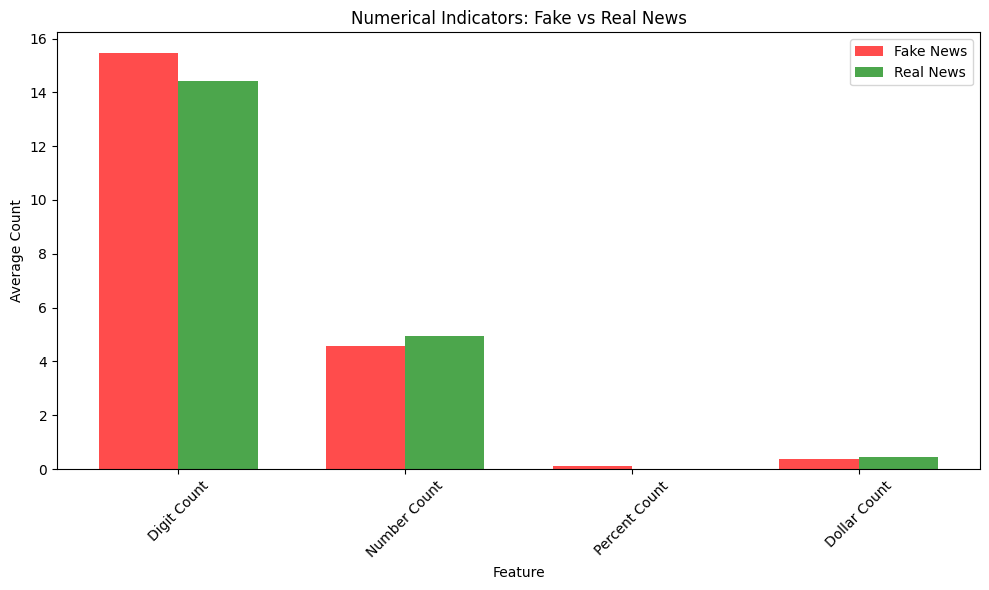

In [ ]:
# Cell 3: Visualization 1 - Bar Chart
feature_means = df.groupby('label_name')[numerical_features].mean()

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(numerical_features))
width = 0.35

ax.bar(x - width/2, feature_means.loc['Fake'], width, label='Fake News', color='red', alpha=0.7)
ax.bar(x + width/2, feature_means.loc['Real'], width, label='Real News', color='green', alpha=0.7)

ax.set_xlabel('Feature')
ax.set_ylabel('Average Count')
ax.set_title('Numerical Indicators: Fake vs Real News')
ax.set_xticks(x)
ax.set_xticklabels([f.replace('_', ' ').title() for f in numerical_features], rotation=45)
ax.legend()
plt.tight_layout()
plt.show()

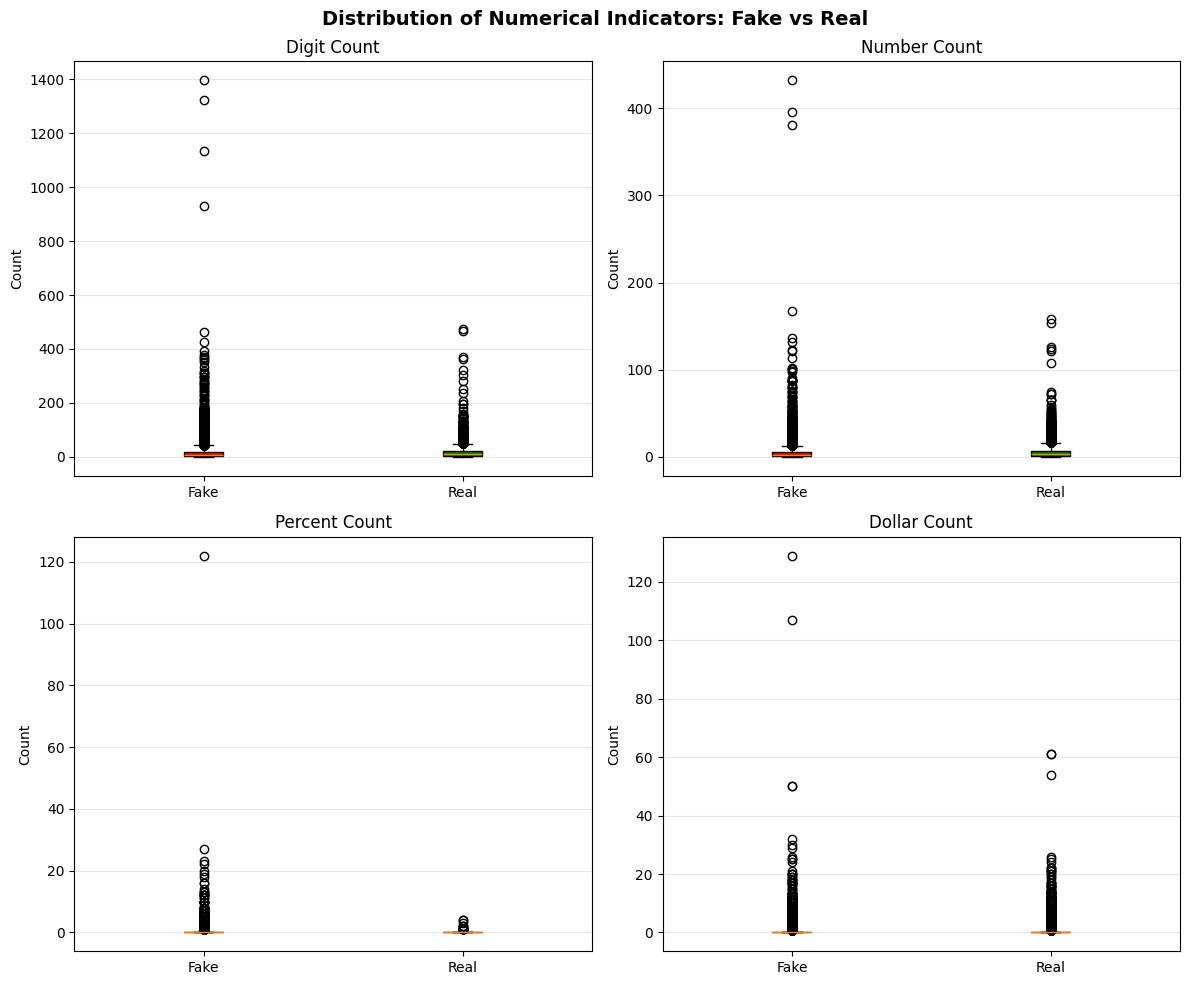

In [ ]:
# Cell 4: Visualization 2 - Boxplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, feature in enumerate(numerical_features):
    ax = axes[idx]
    data_to_plot = [df[df['label_name'] == 'Fake'][feature],
                    df[df['label_name'] == 'Real'][feature]]

    bp = ax.boxplot(data_to_plot, labels=['Fake', 'Real'], patch_artist=True)
    bp['boxes'][0].set_facecolor('red')
    bp['boxes'][1].set_facecolor('green')

    ax.set_title(feature.replace('_', ' ').title())
    ax.set_ylabel('Count')
    ax.grid(axis='y', alpha=0.3)

plt.suptitle('Distribution of Numerical Indicators: Fake vs Real', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [ ]:
#Topic Modeling + Additional Feature Insights
# STEP 1 — Re-join tokens
df['tokens_joined'] = df['tokens'].apply(lambda x: " ".join(x))
# STEP 2 — CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    max_df=0.5,
    min_df=10,
    stop_words='english'
)

dtm = vectorizer.fit_transform(df['tokens_joined'])
print("DTM shape:", dtm.shape)
# STEP 3 — Fit LDA Model
from sklearn.decomposition import LatentDirichletAllocation

lda_model = LatentDirichletAllocation(
    n_components=10,
    learning_method='batch',
    random_state=42,
    n_jobs=-1
)

lda_model.fit(dtm)
# STEP 4 — Print Topics
def display_topics(model, feature_names, num_words=15):
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic {topic_idx}:")
        print("  ".join([feature_names[i]
                         for i in topic.argsort()[:-num_words - 1:-1]]))
,
feature_names = vectorizer.get_feature_names_out()
display_topics(lda_model, feature_names)


DTM shape: (39105, 15743)

Topic 0:
compani  state  year  new  administr  govern  trade  mexico  busi  million  rule  unit  industri  agenc  bank

Topic 1:
russia  russian  intellig  elect  putin  report  moscow  news  offici  secur  syria  agenc  committe  state  foreign

Topic 2:
peopl  like  imag  video  donald  time  know  make  think  obama  want  american  thing  america  women

Topic 3:
republican  democrat  clinton  senat  campaign  parti  elect  candid  state  presidenti  support  vote  sander  poll  nomin

Topic 4:
state  north  china  unit  korea  nuclear  militari  offici  iran  countri  missil  deal  south  foreign  sanction

Topic 5:
republican  tax  hous  senat  state  plan  democrat  legisl  year  congress  fund  percent  law  vote  pass

Topic 6:
polic  kill  attack  peopl  state  group  islam  forc  muslim  govern  year  secur  citi  report  militari

Topic 7:
clinton  hous  investig  white  report  campaign  fbi  email  hillari  depart  comey  obama  new  time  offic

Topic 0 — Business, Trade, Economics
[company, trade, industry, bank, million, agency, rule]

Main theme: economic policy / business news.

Topic 1 — Russia, Intelligence, Geopolitics
[russia, putin, moscow, intelligence, foreign]

Main theme: Russia, foreign affairs, intelligence reports.

Topic 2 — Human Interest / Politics + Social Commentary
[people, like, video, obama, think, want, american]

This is a general emotional/opinion/social media style topic — common in fake news.

Topic 3 — Elections & Campaign Politics
[republican, democrat, clinton, election, senator, nominee]

Classic US election/political campaign topic.

Topic 4 — International Security / Nuclear Politics
[china, north korea, nuclear, iran, missile, sanctions]

Foreign security issues — North Korea + Iran + China.

Topic 5 — Congress, Legislation, Taxes
[tax, senate, plan, congress, law, pass]

Domestic policy / budget / tax reform.

Topic 6 — Terrorism, Violence, Police
[police, attack, islam, muslim, military, security]

Topic focused on violent events / terrorism / law enforcement.

Topic 7 — Clinton, FBI, Email Investigations
[clinton, fbi, email, comey, investigation]

A separate, very clear topic. Fake news datasets often split this out strongly.

Topic 8 — EU/Europe Politics
[eu, european, parliament, britain, prime, vote]

European political leaders & elections.

Topic 9 — Courts, Immigration Law
[court, immigration, judge, justice, ban]

Supreme court, immigration rulings.

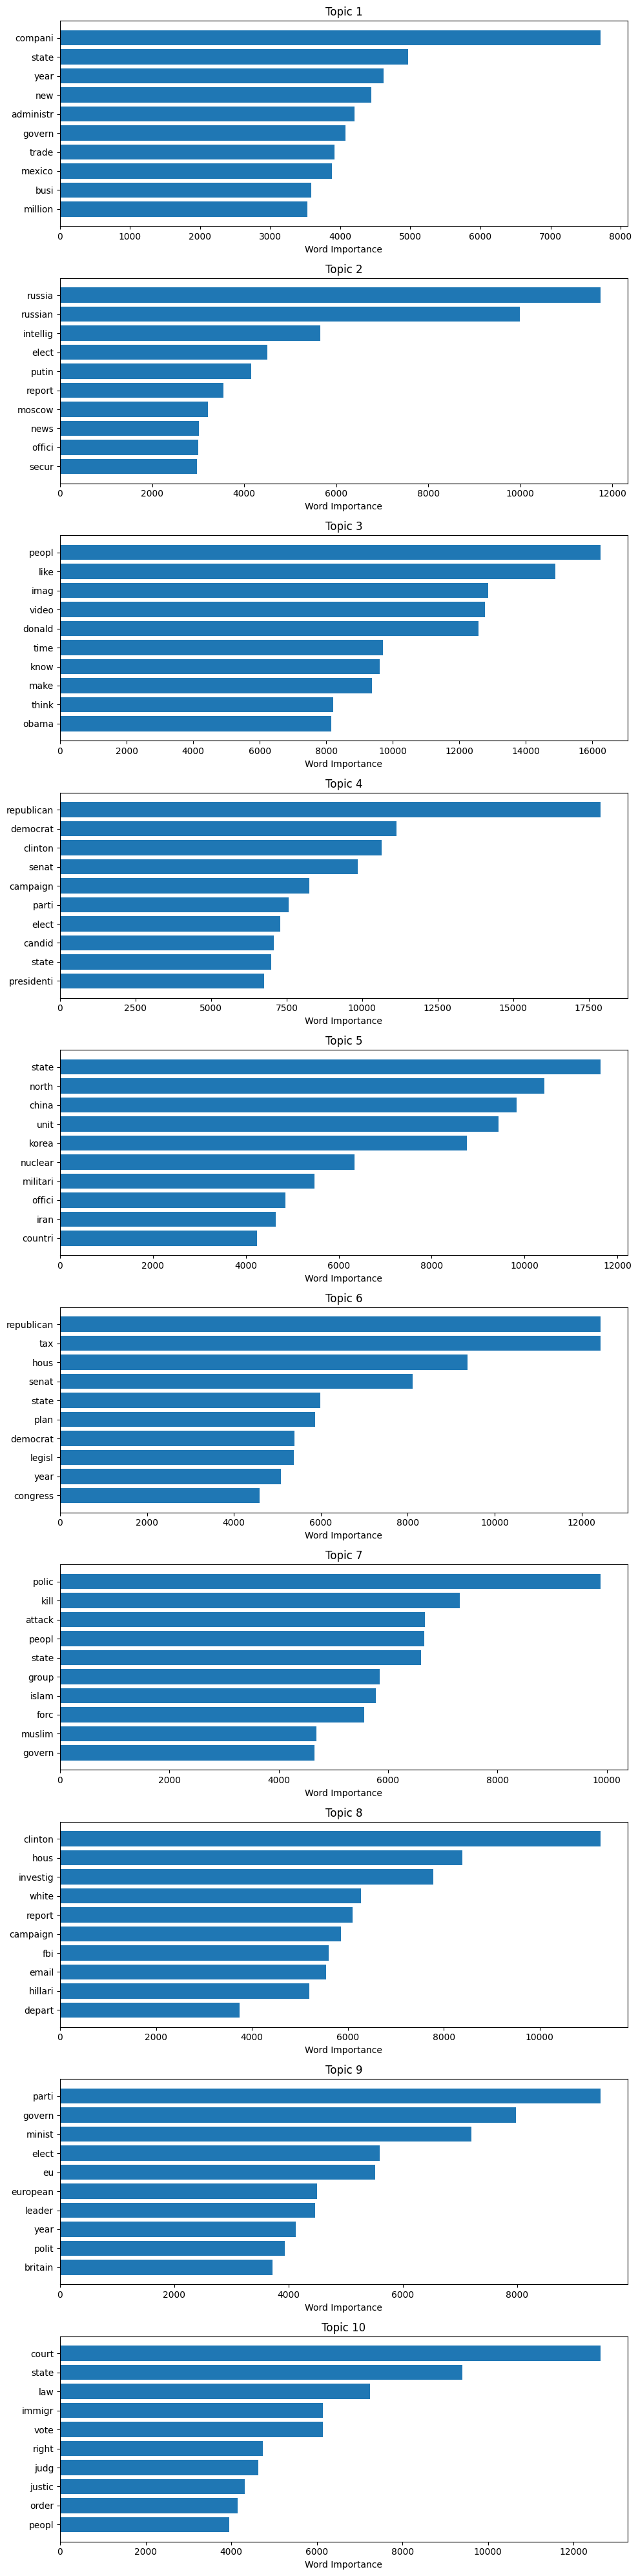

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

#Feature names
feature_names = vectorizer.get_feature_names_out()

def plot_top_words(model, feature_names, n_top_words=10):
    num_topics = model.components_.shape[0]
    fig, axes = plt.subplots(num_topics, 1, figsize=(10, 4 * num_topics))

    if num_topics == 1:
        axes = [axes]

    for topic_idx, topic in enumerate(model.components_):
        top_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_idx]
        top_values = topic[top_idx]

        ax = axes[topic_idx]
        ax.barh(top_words, top_values)
        ax.invert_yaxis()
        ax.set_title(f"Topic {topic_idx + 1}")
        ax.set_xlabel("Word Importance")

    plt.tight_layout()
    plt.show()

plot_top_words(lda_model, feature_names)


In [ ]:
import warnings
warnings.filterwarnings("ignore")
!pip install pyLDAvis

import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()

vis = pyLDAvis.lda_model.prepare(
    lda_model,  #fitted sklearn LDA model
    dtm,        #document-term matrix
    vectorizer  #CountVectorizer used to create DTM
)


vis



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 35.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 55.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.163295  0.094448       1        1  22.589718
6     -0.077034  0.203458       2        1  11.026960
0     -0.079198 -0.073416       3        1   9.469283
5      0.018764 -0.085499       4        1   9.113588
3      0.036893 -0.110383       5        1   9.002259
4     -0.163283 -0.016928       6        1   8.554306
8     -0.098318 -0.002373       7        1   8.475795
7      0.132886 -0.032351       8        1   8.290873
9      0.039987  0.058284       9        1   8.201313
1      0.026007 -0.035239      10        1   5.275904, topic_info=             Term          Freq         Total Category  logprob  loglift
11669  republican  37599.000000  37599.000000  Default  30.0000  30.0000
2596      clinton  24044.000000  24044.000000  Default  29.0000  29.0000
12065      russia  12664.000000  12664.000000  Default  28.0000  28.0000
12067     russian  10022.000000  10022.000000  Default  27.0000  27.0000
3102        court  15405.000000  15405.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
5842       govern   2059.855104  26684.045007  Topic10  -5.2633   0.3806
2049     campaign   1799.479139  21570.565666  Topic10  -5.3985   0.4582
12455       senat   1756.197290  22417.275830  Topic10  -5.4228   0.3953
4057       donald   1686.206844  26110.489547  Topic10  -5.4635   0.2022
13077       sourc   1489.518147   7394.019407  Topic10  -5.5875   1.3398

[877 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
8          2  0.995876    abadi
33         1  0.001001      abe
33         6  0.864095      abe
33         7  0.133169      abe
33         8  0.001001      abe
...      ...       ...      ...
15719      6  0.968598     zika
15721      7  0.998942  zimbabw
15727      3  0.979875     zink
15727      8  0.015311     zink
15741      7  0.998303     zuma

[3395 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 7, 1, 6, 4, 5, 9, 8, 10, 2])

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
# topic distribution for each document
topic_matrix = lda_model.transform(dtm)
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
# Dominant topic per document
df['dominant_topic'] = topic_matrix.argmax(axis=1)

df[['full_text', 'dominant_topic']].head()


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

,full_text,dominant_topic
0,donald trump sends out embarrassing new year’s...,2
1,drunk bragging trump staffer started russian c...,7
2,sheriff david clarke becomes an internet joke ...,2
3,trump is so obsessed he even has obama’s name ...,2
4,pope francis just called out donald trump duri...,6


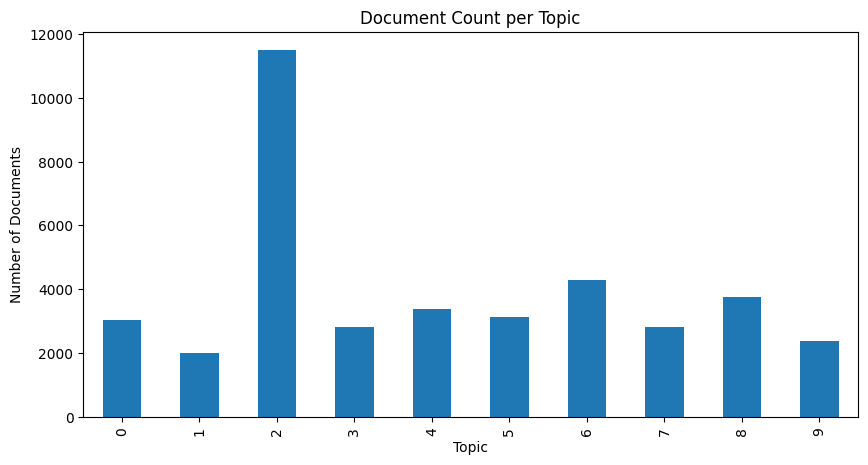

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(10,5))
df['dominant_topic'].value_counts().sort_index().plot(kind='bar')
plt.title("Document Count per Topic")
plt.xlabel("Topic")
plt.ylabel("Number of Documents")
plt.show()


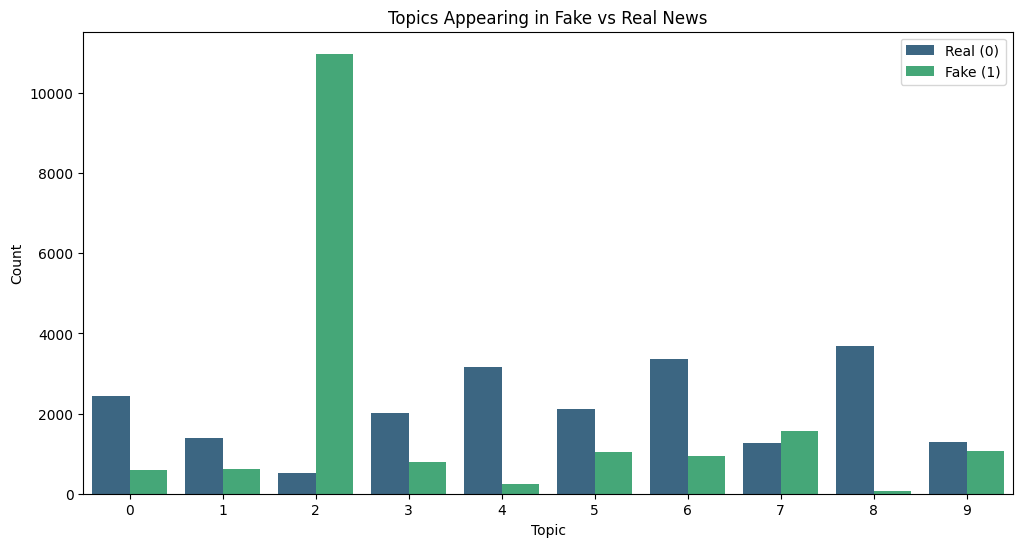

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(data=df, x='dominant_topic', hue='label', palette="viridis")
plt.title("Topics Appearing in Fake vs Real News")
plt.xlabel("Topic")
plt.ylabel("Count")
plt.legend(labels=["Real (0)", "Fake (1)"])
plt.show()


In [ ]:
# SECTION 1: SETUP & DATA LOADING
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

#Load cleaned dataset
data_path = "/content/cleaned_news_dataset.csv"
df = pd.read_csv(data_path)

print("Data shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

print("\nLabel value counts:")
print(df['label'].value_counts())

print("\nMissing values:")
print(df.isna().sum())

df = df.dropna(subset=['label', 'text', 'title', 'full_text'])
df = df.reset_index(drop=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data shape: (39105, 9)
Columns: ['title', 'text', 'subject', 'date', 'label', 'title_clean', 'text_clean', 'full_text', 'tokens']
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                dat

In [ ]:
#SECTION 2: FEATURE ENGINEERING
#Structural features
df['title_len'] = df['title'].fillna("").str.len()
df['text_len'] = df['text'].fillna("").str.len()
df['num_exclam'] = df['text'].fillna("").str.count('!')
df['num_question'] = df['text'].fillna("").str.count(r'\?')
df['num_digits'] = df['text'].fillna("").str.count(r'\d')

print("\nStructural feature examples:")
print(df[['title_len', 'text_len', 'num_exclam', 'num_question', 'num_digits']].head())

#LIWC-style + pronouns + ALL-CAPS
df['full_text'] = df['full_text'].fillna("").astype(str)

def tokenize(text):
    """Simple tokenizer: lowercase and alphabetic tokens."""
    return re.findall(r"[a-z']+", text.lower())

# Simple lexicons approximating LIWC categories
posemo_words = {
    'good','great','happy','joy','love','excellent','positive','success',
    'win','bright','amazing','wonderful','hope','optimistic','strong'
}
negemo_words = {
    'bad','terrible','sad','anger','angry','hate','horrible','negative',
    'worse','worst','fail','fear','afraid','disaster','crisis','tragic',
    'lie','corrupt','scandal','fake'
}
cogproc_words = {
    'think','know','believe','understand','because','reason','why','cause',
    'effect','evidence','explain','consider','decide','logic','analyze',
    'assume','conclude','argue','suggest'
}
tentat_words = {
    'maybe','perhaps','possibly','might','could','seems','appear','suggest',
    'uncertain','likely','unlikely','apparently','presumably','approximately'
}
certain_words = {
    'always','never','definitely','clearly','certainly','undeniable',
    'undoubtedly','prove','must','will','fact','obvious','sure','guaranteed'
}
first_person_words = {'i','me','my','mine','we','us','our','ours'}
third_person_words = {'he','him','his','she','her','hers','they','them','their','theirs'}

def ratio(tokens, category_words):
    if not tokens:
        return 0.0
    count = sum(1 for t in tokens if t in category_words)
    return count / len(tokens)

posemo_vals = []
negemo_vals = []
cogproc_vals = []
tentat_vals = []
certain_vals = []
firstp_vals = []
thirdp_vals = []
allcaps_vals = []

for original_text, clean_text in zip(df['text'], df['full_text']):
    toks = tokenize(clean_text)
    posemo_vals.append(ratio(toks, posemo_words))
    negemo_vals.append(ratio(toks, negemo_words))
    cogproc_vals.append(ratio(toks, cogproc_words))
    tentat_vals.append(ratio(toks, tentat_words))
    certain_vals.append(ratio(toks, certain_words))
    firstp_vals.append(ratio(toks, first_person_words))
    thirdp_vals.append(ratio(toks, third_person_words))

    # ALL CAPS ratio from original text
    words_original = re.findall(r"\b\w+\b", str(original_text))
    if len(words_original) == 0:
        allcaps_vals.append(0.0)
    else:
        caps_count = sum(1 for w in words_original if w.isupper() and len(w) > 1)
        allcaps_vals.append(caps_count / len(words_original))

df['posemo'] = posemo_vals
df['negemo'] = negemo_vals
df['cogproc'] = cogproc_vals
df['tentat'] = tentat_vals
df['certain'] = certain_vals
df['firstp_ratio'] = firstp_vals
df['thirdp_ratio'] = thirdp_vals
df['allcaps_ratio'] = allcaps_vals

print("\nLIWC-style feature examples:")
print(df[['posemo','negemo','cogproc','tentat','certain',
         'firstp_ratio','thirdp_ratio','allcaps_ratio']].head())

# ---- Final feature set ----
structural_cols = ['title_len', 'text_len', 'num_exclam', 'num_question', 'num_digits']
liwc_cols = ['posemo', 'negemo', 'cogproc', 'tentat', 'certain',
             'firstp_ratio', 'thirdp_ratio', 'allcaps_ratio']

feature_cols = structural_cols + liwc_cols

X = df[feature_cols].astype(float)
y = df['label'].astype(int)

print("\nFeature matrix shape:", X.shape)
print("Target shape:", y.shape)


Structural feature examples:
   title_len  text_len  num_exclam  num_question  num_digits
0         79      2893           6             9         110
1         69      1898           0             0           4
2         90      3597           2             4          99
3         78      2774           0             1          75
4         70      2346           0             0           0

LIWC-style feature examples:
     posemo    negemo   cogproc    tentat   certain  firstp_ratio  \
0  0.020619  0.012371  0.004124  0.000000  0.008247      0.020619   
1  0.003086  0.003086  0.000000  0.000000  0.000000      0.006173   
2  0.001672  0.013378  0.006689  0.001672  0.006689      0.030100   
3  0.002203  0.000000  0.000000  0.002203  0.008811      0.008811   
4  0.002304  0.000000  0.004608  0.000000  0.002304      0.020737   

   thirdp_ratio  allcaps_ratio  
0      0.032990       0.000000  
1      0.021605       0.006329  
2      0.036789       0.050903  
3      0.024229       0.010

In [ ]:
#SECTION 3: TRAIN/TEST SPLIT & SCALING
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, df.index, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# SECTION 4: MODELS - FINAL
from sklearn.model_selection import GridSearchCV

def evaluate_model(name, y_true, y_pred, y_prob=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
    print(f"\n{name}")
    print("-" * len(name))
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {auc:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, digits=3))
    return acc, prec, rec, f1, auc

performance_rows = []

#4A. Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_log = logreg.predict(X_test_scaled)
y_prob_log = logreg.predict_proba(X_test_scaled)[:, 1]

acc, prec, rec, f1, auc = evaluate_model("Logistic Regression", y_test, y_pred_log, y_prob_log)
performance_rows.append(["Logistic Regression", acc, prec, rec, f1, auc])


#4B. Random Forest - Final Model
# These are the best hyperparameters found by GridSearchCV:
# {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1,
#  'min_samples_split': 5, 'n_estimators': 800}

rf_best_params = {
    "n_estimators": 800,
    "max_depth": 20,
    "min_samples_split": 5,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "bootstrap": True,
    "random_state": 42,
    "n_jobs": -1
}

rf_final = RandomForestClassifier(**rf_best_params)
rf_final.fit(X_train, y_train)

y_pred_rf = rf_final.predict(X_test)
y_prob_rf = rf_final.predict_proba(X_test)[:, 1]

acc, prec, rec, f1, auc = evaluate_model("Random Forest (Final, Tuned)", y_test, y_pred_rf, y_prob_rf)
performance_rows.append(["Random Forest (Final, Tuned)", acc, prec, rec, f1, auc])

#4C. Linear SVM
svm = SVC(
    kernel='linear',
    probability=True,
    random_state=42
)
svm.fit(X_train_scaled, y_train)
y_pred_svm = svm.predict(X_test_scaled)
y_prob_svm = svm.predict_proba(X_test_scaled)[:, 1]

acc, prec, rec, f1, auc = evaluate_model("Linear SVM", y_test, y_pred_svm, y_prob_svm)
performance_rows.append(["Linear SVM", acc, prec, rec, f1, auc])

perf_df = pd.DataFrame(
    performance_rows,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "ROC_AUC"]
)

print("\nOverall performance summary:")
print(perf_df)


Logistic Regression
-------------------
Accuracy:  0.8914
Precision: 0.9102
Recall:    0.8465
F1-score:  0.8772
ROC-AUC:   0.9437

Confusion Matrix:
[[3940  299]
 [ 550 3032]]

Classification Report:
              precision    recall  f1-score   support

           0      0.878     0.929     0.903      4239
           1      0.910     0.846     0.877      3582

    accuracy                          0.891      7821
   macro avg      0.894     0.888     0.890      7821
weighted avg      0.892     0.891     0.891      7821


Random Forest (Final, Tuned)
----------------------------
Accuracy:  0.9270
Precision: 0.9286
Recall:    0.9107
F1-score:  0.9195
ROC-AUC:   0.9765

Confusion Matrix:
[[3988  251]
 [ 320 3262]]

Classification Report:
              precision    recall  f1-score   support

           0      0.926     0.941     0.933      4239
           1      0.929     0.911     0.920      3582

    accuracy                          0.927      7821
   macro avg      0.927     0.926  


Random Forest feature importances:
          feature  importance
0       title_len    0.392146
3    num_question    0.118469
12  allcaps_ratio    0.080924
1        text_len    0.073663
11   thirdp_ratio    0.068039
2      num_exclam    0.065298
7         cogproc    0.057457
10   firstp_ratio    0.038903
6          negemo    0.025953
4      num_digits    0.024398
9         certain    0.022085
5          posemo    0.018081
8          tentat    0.014585


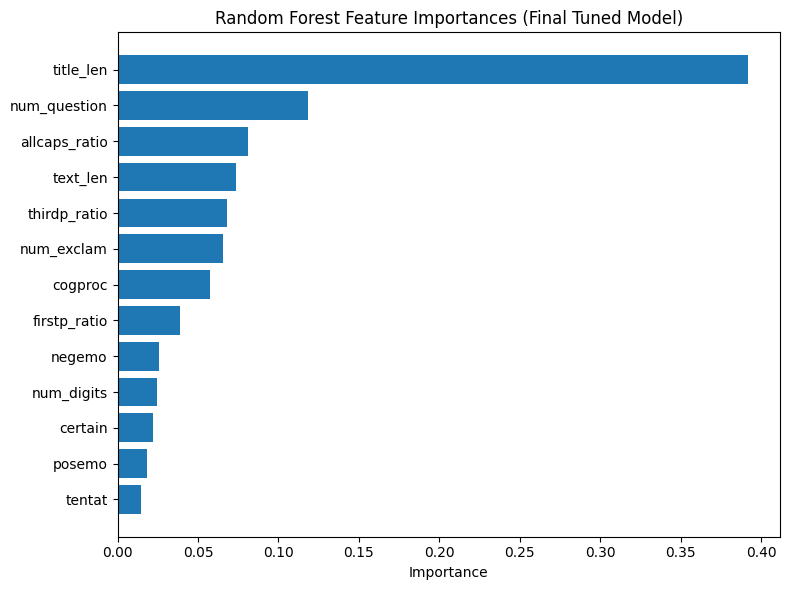

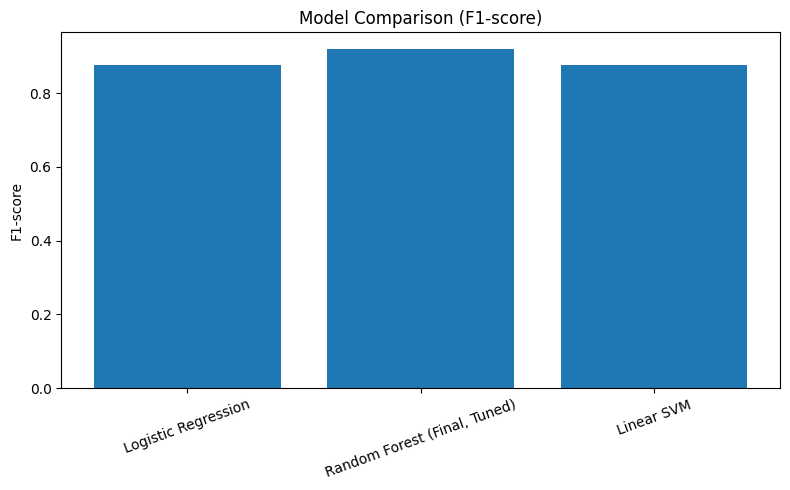


Number of false positives: 251
Number of false negatives: 320

Sample False Positives (real labeled as fake):
                                                   title       subject  \
20550  Trump says he should not have picked Sessions ...  politicsNews   
25932  Biden warns Ukraine on reforms, says EU sancti...  politicsNews   
29019  Obama does victory lap for car industry but it...  politicsNews   
21199  Q&A: What we know about U.S. probes of Russian...  politicsNews   
29387  Malaysian PM Najib says will use all means to ...     worldnews   

       y_true  y_pred_rf  
20550       0          1  
25932       0          1  
29019       0          1  
21199       0          1  
29387       0          1  

Sample False Negatives (fake labeled as real):
                                                   title   subject  y_true  \
12626  LOL! Clinton News Network (CNN) SHUT DOWN At T...  politics       1   
17901  How to Blow $700 Million: Al Jazeera America F...   US_News       1   


In [ ]:
# SECTION 5: INTERPRETATION & VISUALS
importances = rf_final.feature_importances_

feat_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nRandom Forest feature importances:")
print(feat_importance_df)

plt.figure(figsize=(8, 6))
plt.barh(
    feat_importance_df['feature'][::-1],
    feat_importance_df['importance'][::-1]
)
plt.xlabel("Importance")
plt.title("Random Forest Feature Importances (Final Tuned Model)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
x = np.arange(len(perf_df))
plt.bar(x, perf_df['F1'])
plt.xticks(x, perf_df['Model'], rotation=20)
plt.ylabel('F1-score')
plt.title('Model Comparison (F1-score)')
plt.tight_layout()
plt.show()

# SECTION 6: ERROR ANALYSIS

df_test = df.loc[idx_test].copy()
df_test['y_true'] = y_test.values
df_test['y_pred_rf'] = y_pred_rf

fp_mask = (df_test['y_true'] == 0) & (df_test['y_pred_rf'] == 1)
fn_mask = (df_test['y_true'] == 1) & (df_test['y_pred_rf'] == 0)

false_positives = df_test[fp_mask]
false_negatives = df_test[fn_mask]

print("\nNumber of false positives:", len(false_positives))
print("Number of false negatives:", len(false_negatives))

print("\nSample False Positives (real labeled as fake):")
print(false_positives[['title', 'subject', 'y_true', 'y_pred_rf']].head(5))

print("\nSample False Negatives (fake labeled as real):")
print(false_negatives[['title', 'subject', 'y_true', 'y_pred_rf']].head(5))